# **Data base**

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy import stats

df = pd.read_csv('full_table.csv')
df.head()

,uid,id,country,gender,group,dt,total_spent,group.1,join_dt,device,join_dt.1
0,1000000,1000000,CAN,M,B,NaN,0.0,B,2023-01-28,I,2023-01-28
1,1000001,1000001,BRA,M,A,NaN,0.0,A,2023-01-27,A,2023-01-27
2,1000002,1000002,FRA,M,A,NaN,0.0,A,2023-02-01,A,2023-02-01
3,1000003,1000003,BRA,M,B,NaN,0.0,B,2023-01-25,I,2023-01-25
4,1000004,1000004,DEU,F,A,NaN,0.0,A,2023-02-04,A,2023-02-04


# **Confirming test results**.
Our target randomization unit of the test – individual users. It makes a convenient experimental unit and compare the average spent and conversion rate across two groups.
The groups have significant size and roughly comparable and have similar demographics

In [13]:
# Are groups the same size?
results = df.groupby('group').agg({'uid':pd.Series.nunique})
unique_users = len(df.uid.unique())
results = results / unique_users * 100
print(f'groupds are roughly comparable:\n'
      f'% {results}')

# Convert the 'date' column to a datetime object
df['dt'] = pd.to_datetime(df['dt'])

# Calculate the period between the smallest date and the last date
period = df['dt'].max() - df['dt'].min()

print(f"The testing period is: {period}")

groupds are roughly comparable:
%             uid
group          
A      49.73745
B      50.26255
The testing period is: 12 days 00:00:00


Is our group random?

In [14]:
# Do our groups have similar demographics?
results = df.groupby(
    by = ['group', 'gender','device']).agg({'uid':pd.Series.nunique})
# Find the overall number of unique users using "len" and "unique"
unique_users = len(df.uid.unique())

# Find the percentage in each group
results = round((results / unique_users * 100), 1)
print(results)
print('Result is truly random')

                      uid
group gender device      
A     F      A       12.7
             I        7.8
      M      A       12.7
             I        7.7
      O      A        1.0
             I        0.6
B     F      A       12.8
             I        7.6
      M      A       12.8
             I        8.0
      O      A        1.2
             I        0.6
Result is truly random


# **Caulculation of the size of each group and number of converted users**


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import t
import scipy.stats as stats
import math
from scipy.stats import norm

# Convert the 'total_spent' column to a valid data type
df['total_spent'] = df['total_spent'].astype(float)
df['total_spent'] = pd.to_numeric(df['total_spent'], errors='coerce')

# Drop rows with missing values in the 'total_spent' column
df = df[df['total_spent'].notna()]

# Create a new column called 'converted' that indicates whether or not a user was converted
df['converted'] = df['total_spent'] > 0

# Split the DataFrame into two groups based on the 'group' column
group_a = df[df['group'] == 'A']
group_b = df[df['group'] == 'B']

# Calculate the number of uid and the number of users with total_spent > 0 for each group
num_uid_group_a = len(group_a['uid'].unique())
num_uid_group_b = len(group_b['uid'].unique())

# Calculate the number of converted users in group B
num_converted_b = len(df[(df['group'] == 'B') & (df['converted'] == True)])
num_converted_a = len(df[(df['group'] == 'A') & (df['converted'] == True)])

print(f'Control Group:\n'
      f'Number of unique uid: {num_uid_group_a}\n'
      f'Number of users with total_spent > 0 (CONVERTED): {num_converted_a}\n')
print(f'Treatment Group:\n'
      f'Number of unique uid: {num_uid_group_b}\n'
      f'Number of users with total_spent > 0 (CONVERTED): {num_converted_b}\n')

Control Group:
Number of unique uid: 24343
Number of users with total_spent > 0 (CONVERTED): 1014

Treatment Group:
Number of unique uid: 24600
Number of users with total_spent > 0 (CONVERTED): 1219



# **Conversion Rate of the population.**

In [16]:
# Calculate conversion rate of the population 
num_users = num_uid_group_a + num_uid_group_a

converted_users = num_converted_b + num_converted_a
conversion_rate = converted_users / num_users

# Calculate the variance and standard error for the population
var = (conversion_rate * (1 - conversion_rate))/num_users
se = var**0.5

print("Conversion rate: {:.2%}".format(conversion_rate))
print(f'Variation: {var}\n'
     f'Standard error: {se}\n')
print("The conversion rate doesn't vary a lot among users - it will be easy to detect a change")

Conversion rate: 4.59%
Variation: 8.988561731417552e-07
Standard error: 0.000948080256698638

The conversion rate doesn't vary a lot among users - it will be easy to detect a change


# **Conversion Rate of the control and treatment group**

In [17]:
# Calculate conversion rate for Group A
group_a_conversion_rate = (num_converted_a / num_uid_group_a) 
# Compute the standard deviation
control_sd = ((group_a_conversion_rate * (1 - group_a_conversion_rate)) / num_uid_group_a)**0.5

print("Conversion rate for control group: {:.2%}".format(group_a_conversion_rate),f', std  = {control_sd}')

# Calculate conversion rate for Group B
group_b_conversion_rate = (num_converted_b / num_uid_group_b) 
# Compute the standard deviation
treatment_sd = ((group_b_conversion_rate * (1 - group_b_conversion_rate)) / num_uid_group_b)**0.5

print("Conversion rate for treatment group: {:.2%}".format(group_b_conversion_rate),f', std  = {treatment_sd}')

Conversion rate for control group: 4.17% , std  = 0.0012805775693302019
Conversion rate for treatment group: 4.96% , std  = 0.00138366429132097


# **95% confidence intervals** for the conversion rate of users in the control and treatment group

In [18]:
# Calculate the confidential interval of the conversion rate Group A
std_error_a = np.sqrt(group_a_conversion_rate * (1 - group_a_conversion_rate) / num_uid_group_a)
margin_of_error_a = norm.ppf(0.975) * std_error_a
conf_interval_a = (group_a_conversion_rate - margin_of_error_a, group_a_conversion_rate + margin_of_error_a)
print("95% Confidence interval for the conversion rate of users in the control group:", conf_interval_a)

# Calculate the confidential interval of the conversion rate Group B
std_error_b = np.sqrt(group_b_conversion_rate * (1 - group_b_conversion_rate) / num_uid_group_b)
margin_of_error_b = norm.ppf(0.975) * std_error_b
conf_interval_b = (group_b_conversion_rate - margin_of_error_b, group_b_conversion_rate + margin_of_error_b)
print("95% Confidence interval for the conversion rate of users in the treatmen group:", conf_interval_b)

# Calculate the variance 
variance_a = (group_a_conversion_rate * (1 - group_a_conversion_rate)) / num_uid_group_a
variance_b = (group_b_conversion_rate * (1 - group_b_conversion_rate)) / num_uid_group_b
print(f'Variance control group: {variance_a}\n'
      f'Variance treatment group: {variance_b}')

# Calculate the standard deviations
control_sd = ((group_a_conversion_rate * (1 - group_a_conversion_rate)) / num_uid_group_a)**0.5
treatment_sd = ((group_b_conversion_rate * (1 - group_b_conversion_rate)) / num_uid_group_b)**0.5
print(f'Standard deviation control group: {control_sd}\n'
      f'Standard deviation  treatment group: {treatment_sd}')

95% Confidence interval for the conversion rate of users in the control group: (0.03914479920979025, 0.044164571040384334)
95% Confidence interval for the conversion rate of users in the treatmen group: (0.04684091335077205, 0.05226477770613852)
Variance control group: 1.6398789110716478e-06
Variance treatment group: 1.9145268710767617e-06
Standard deviation control group: 0.0012805775693302019
Standard deviation  treatment group: 0.00138366429132097


# **95% Confidence Interval for Difference in Conversion Rate**

95% confidence interval for the difference in conversion rates: [0.0042, 0.0116]


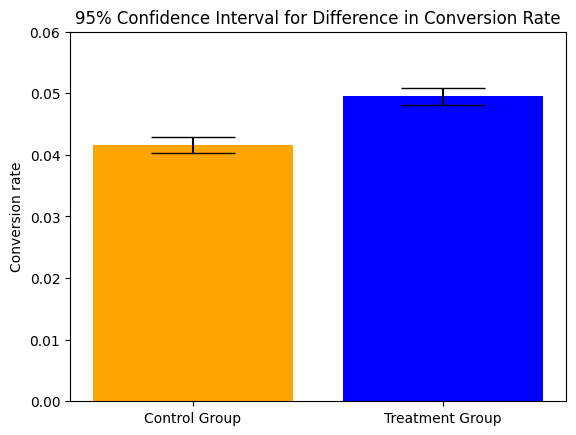

In [19]:
# calculate confidence interval for difference treatment and control group
alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)

# Calculate unpooled standard error
se_diff = np.sqrt(std_error_a**2 + std_error_b**2)

# Calculate the difference in conversion rates
diff = group_b_conversion_rate - group_a_conversion_rate

# Calculate the margin of error
margin_of_error = z * se_diff

# Calculate the confidence interval
ci_lower = diff - margin_of_error
ci_upper = diff + margin_of_error

print(f"95% confidence interval for the difference in conversion rates: [{ci_lower:.4f}, {ci_upper:.4f}]")

# plot bar chart with error bars
fig, ax = plt.subplots()
ax.bar(['Control Group', 'Treatment Group'], [group_a_conversion_rate, group_b_conversion_rate], yerr=[std_error_a, std_error_b], capsize=30, color= ['orange', 'blue'])

ax.set_ylim([0, 0.06])
ax.set_ylabel('Conversion rate')
ax.set_title('95% Confidence Interval for Difference in Conversion Rate')

plt.show()




# **Plotting the distribution**
 visualize the test and control conversion rates as distributions. 

0.7898160403367989


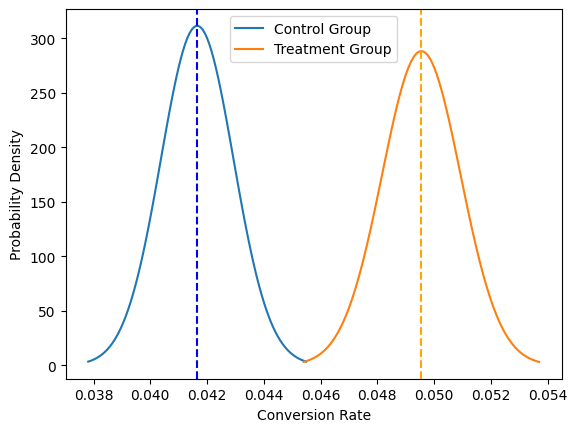

In [20]:
# Create the range of x values 
control_line = np.linspace(group_a_conversion_rate - 3 * control_sd, group_a_conversion_rate + 3 * control_sd, 100)
test_line = np.linspace(group_b_conversion_rate - 3 * treatment_sd, group_b_conversion_rate + 3 * treatment_sd, 100)
d = group_b_conversion_rate*100 - group_a_conversion_rate*100

print(d)
# Plot the distribution     
plt.plot(control_line, norm.pdf(control_line, group_a_conversion_rate, control_sd), label='Control Group')
plt.plot(test_line, norm.pdf(test_line, group_b_conversion_rate, treatment_sd), label='Treatment Group')
plt.axvline(x=group_a_conversion_rate, linestyle='--', color='blue')
plt.axvline(x=group_b_conversion_rate, linestyle='--', color='orange')

# Add title and axes names
#plt.title('Distribution of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# **p-value**

In [21]:
# use normal distribution and 5% significance level. use pooled proportion for the standard error, 
# use two-sample two-sided z-interval for difference in proportions, pooled standard error. 

# Calculate the pooled proportion
pooled_proportion = (num_converted_a + num_converted_b) / (num_uid_group_a + num_uid_group_b)

# Calculate the standard error using the pooled proportion
pooled_standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) 
* (1 / num_uid_group_a + 1 / num_uid_group_b))

# Calculate the difference in proportions
prop_diff = num_converted_b / num_uid_group_b - num_converted_a / num_uid_group_a

# Calculate the z-interval
z_critical = norm.ppf(0.975)  # 5% significance level (two-tailed)

# Calculate the p-value
z_stat = prop_diff / pooled_standard_error
p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # two-sided

# Print the results
print(f'Test statistic: {z_stat:.3f}')
# print(f"95% Confidence interval: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value: {p_value:.5f}")
if p_value <= 0.05:
    print('Conclusion: There is evidence of a difference in conversion rates between the two groups. We reject the null hypothesis.')
else:
    print('Conclusion: There is not enough evidence to conclude that there is a difference in conversion rates between the two groups.')


Test statistic: 4.187
p-value: 0.00003
Conclusion: There is evidence of a difference in conversion rates between the two groups. We reject the null hypothesis.


# **Plotting the difference distribution**
Plot a green vertical line at the distributions mean, and a red vertical lines at each of the lower and upper confidence interval bounds. 

Confidence Interval for the lift observed 0.7898160403367993


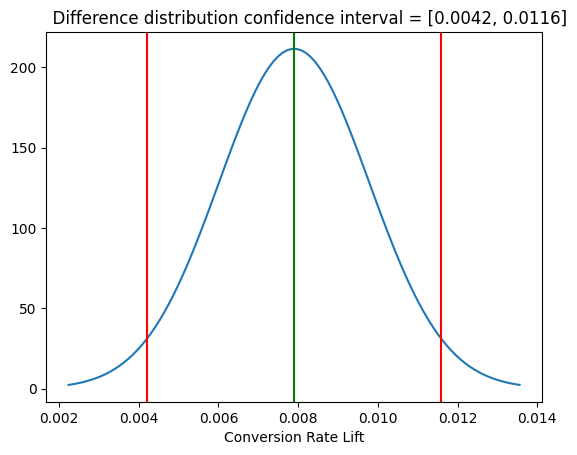

In [22]:
# Find the lift mean and standard deviation
lift_mean = group_b_conversion_rate - group_a_conversion_rate
lift_sd = (variance_a + variance_b) ** 0.5

# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)
print('Confidence Interval for the lift observed', lift_mean*100)
# Plot the lift distribution
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))

# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = ci_lower, color = 'red')
plt.axvline(x = ci_upper, color = 'red')
plt.title(f'      Difference distribution confidence interval = [{ci_lower:.4f}, {ci_upper:.4f}]')
#plt.title('Difference in Conversion Rate')
plt.xlabel('Conversion Rate Lift')

plt.show()